# phageParser - Analysis of Spacer Lengths

C.K. Yildirim (cemyildirim@fastmail.com)

The latest version of this [IPython notebook](http://ipython.org/notebook.html) demo is available at [http://github.com/phageParser/phageParser](https://github.com/phageParser/phageParser/tree/django-dev/demos)

To run this notebook locally:
* `git clone` or [download](https://github.com/phageParser/phageParser/archive/master.zip) this repository
* Install [Jupyter Notebook](http://jupyter.org/install.html)
* In a command prompt, type `jupyter notebook` - the notebook server will launch in your browser
* Navigate to the phageParser/demos folder and open the notebook

## Introduction

This demo uses the REST API of phageParser to plot the distribution of spacer lengths.
In this case, the API is consumed using the requests library and the json responses are parsed for gathering
basepair length information of spacers.

In [1]:
%matplotlib inline

In [2]:
#Import packages
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy.stats import poisson
sns.set_palette("husl")

In [3]:
#Url of the phageParser API
apiurl = 'https://phageparser.herokuapp.com'

In [4]:
#Get the initial page for listing of accessible objects and get url for spacers
r=requests.get(apiurl)
spacerurl = r.json()['organisms']

In [5]:
#API is accessible by chunks of spacers that are in each page, get the total number of pages from meta field
r=requests.get(spacerurl)
last_page = r.json()['meta']['total_pages']

In [6]:
#Iterate through each page and store json response which only has length of spacers information
jbatches = []
for page in range(1,last_page):
    #Exclude every field on spacer object other than length and move to a certain page
    batch_url = spacerurl+'?page={}&exclude[]=*&include[]=loci.spacers.length'.format(page)
    spacer_batch = requests.get(batch_url).json()
    jbatches.append(spacer_batch)

In [7]:
#Get lengths of spacers per locus
org_spacer={}
for batch in jbatches:
    for organism in batch['organisms']:
        locusspacerlens = {}
        if organism['loci'] == []:
            continue
        orgid = organism['loci'][0]['organism']    
        for locus in organism['loci']:
            spacerlens = []
            for spacer in locus['spacers']:
                spacerlens.append(spacer['length'])
            locusspacerlens[locus['id']]=np.array(spacerlens)
        org_spacer[orgid] = locusspacerlens

In [8]:
#Get the global mean and variance
spacerbplengths = np.array([spacerlen for organism in org_spacer.values() for locusspacerlen in organism.values() for spacerlen in locusspacerlen]).flatten()
mu, sigma = spacerbplengths.mean(), spacerbplengths.std()
print("Calculated mean basepair length for spacers is {:.2f}+/-{:.2f}".format(mu,sigma))

Calculated mean basepair length for spacers is 35.11+/-3.95


Across the roughly ~3000 sequenced organisms that have what looks like a CRISPR locus, what is the distribution of CRISPR spacer lengths? The histogram below shows that spacer length is peaked at about 35 base pairs. 

The standard deviation of spacer length is 4 base pairs, but the distribution has large tails - there are many more long spacers than would be expected if the lengths were normally distributed (black dashed line) or Poisson distributed (red dashed line).

Individual organisms (colours other than blue) have tighter distributions than the overall distribution.

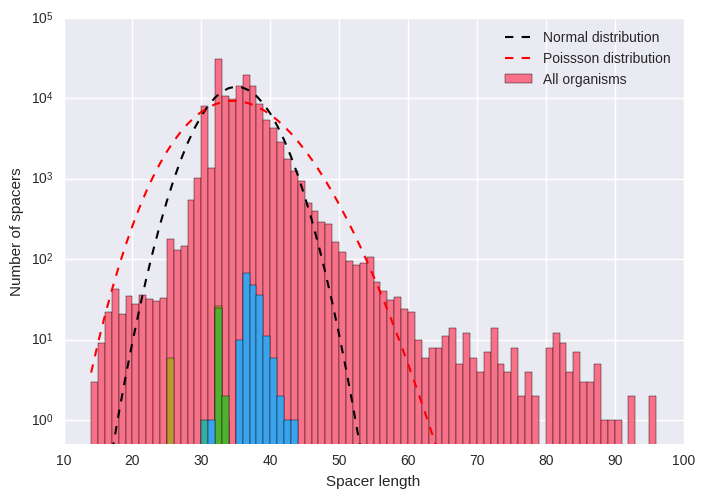

In [9]:
#Plot histogram of spacer lengths across all organisms

norm = False # change to false to show totals, true to show everything normalized to 1

plt.figure()
bins=range(5,100)
plt.hist(spacerbplengths,bins=bins,normed=norm,label='All organisms')
plt.yscale('log')
if norm == False:
    plt.ylim(5*10**-1,10**5)
else:
    plt.ylim(10**-6,10**0)
plt.xlim(10,100)

#Plot normal and poisson distribution of length
x=np.unique(spacerbplengths)
if norm == False:
    y = mlab.normpdf(x, mu, sigma)*len(spacerbplengths)
    y2 = poisson.pmf(x,mu)*len(spacerbplengths)
else:
    y = mlab.normpdf(x, mu, sigma)
    y2 = poisson.pmf(x,mu)
plt.plot(x, y, 'k--', linewidth=1.5, label='Normal distribution')
plt.plot(x, y2, 'r--',linewidth=1.5, label='Poissson distribution')

#Plot histogram for a single organism
for i in range(4):
    org_id = random.choice(list(org_spacer.keys()))
    orgspacerlens = np.concatenate(list(org_spacer[org_id].values()))
    plt.hist(orgspacerlens,bins=bins, normed=norm)

plt.ylabel("Number of spacers")
plt.xlabel("Spacer length")
plt.legend();

What the above plot suggests is that individual organisms and loci have narrow spacer length distributions but that the total distribution is quite broad. 

The mean of all individual locus standard deviations is 1.31, smaller than the spacer length standard deviations for all organisms combined.


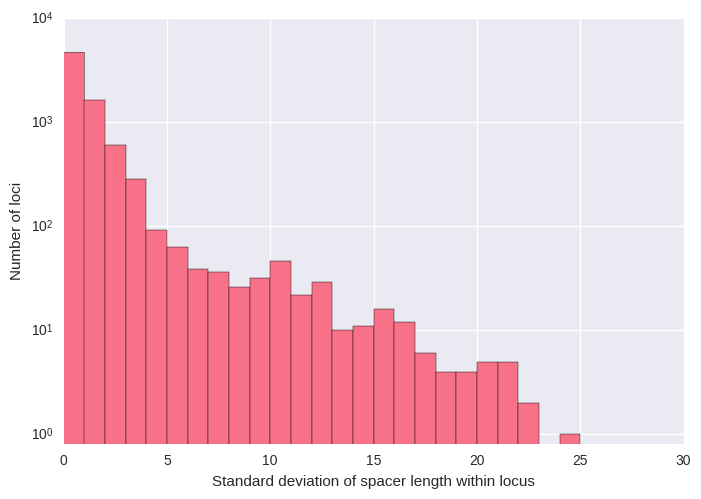

In [13]:
#Calculate means and standard deviations of spacer length for all individual loci
means = []
stds = []
for org in org_spacer.values():
    for arr in list(org.values()):
        means.append(np.mean(arr))
        stds.append(np.std(arr))
        
print("The mean of all individual locus standard deviations is " 
      + str(round(np.mean(stds),2)) 
      + ", smaller than the spacer length standard deviations for all organisms combined.") 
plt.figure()
plt.hist(stds,bins=range(0,30))
plt.xlabel("Standard deviation of spacer length within locus")
plt.ylabel("Number of loci")
plt.ylim(8*10**-1,10**4)
plt.yscale('log');

The following cumulative version of the total spacer length histogram shows again the deviation from normal distribution at large spacer lengths.

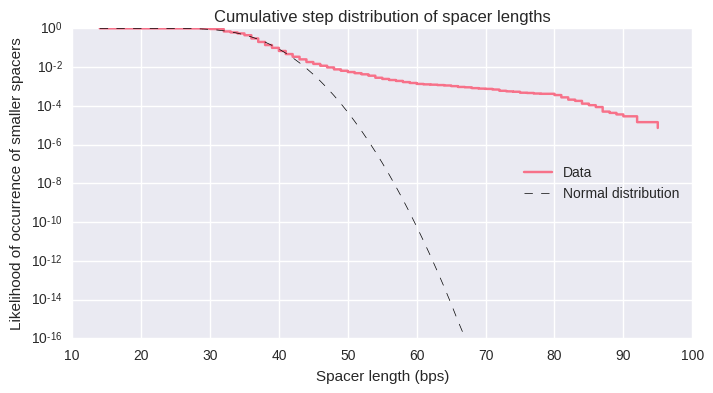

In [11]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
#Plot cumulative probability of data
sorted_data = np.sort(spacerbplengths)
ax.step(sorted_data, 1-np.arange(sorted_data.size)/sorted_data.size, label='Data')
#Plot normal distribution
x=np.unique(sorted_data)
y = mlab.normpdf(x, mu, sigma).cumsum()
y /= y[-1]
ax.plot(x, 1-y, 'k--', linewidth=0.5, label='Normal distribution')

#Format the figure and label
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step distribution of spacer lengths')
ax.set_xlabel("Spacer length (bps)")
ax.set_ylabel('Likelihood of occurrence of smaller spacers')
plt.show()

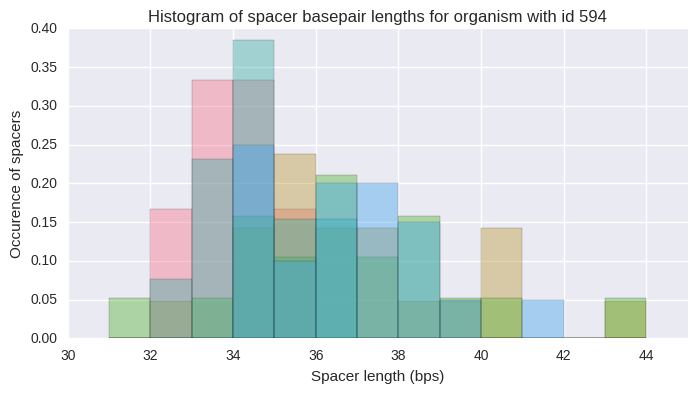

In [12]:
#Pick a random organism to plot the histogram for each locus
org_id = random.choice(list(org_spacer.keys()))
org_id=594
locusspacerlens = org_spacer[org_id]
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
bins=range(30,45,1)
#Plot histogram of spacer length frequency
for loc in locusspacerlens:
    sns.distplot(locusspacerlens[loc], ax=ax, kde=False, norm_hist=True, bins=bins)
plt.xlim([30,45])

#format the figure and label
ax.set_title("Histogram of spacer basepair lengths for organism with id {}".format(org_id))
ax.set_xlabel("Spacer length (bps)")
ax.set_ylabel("Occurence of spacers")
plt.show()